In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [4]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [5]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [6]:
#learning   
l = 1.
step = 300000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)
# a.actor = make_standup_agent(a.actor, .5, env, epochs=100, verbose=False)
a.actor.load_weights('./saved_agent/sample_02.h5')
# a.actor.load_weights('./saved_agent/self_trigger_06.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)







Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 96s 10ms/step - reward: -1.1473
121 episodes - episode_reward: -94.320 [-124.843, -24.714] - loss: 0.220 - mean_squared_error: 0.440 - mean_q: -1.004

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -0.3718
127 episodes - episode_reward: -29.772 [-96.541, 11.302] - loss: 0.138 - mean_squared_error: 0.275 - mean_q: -0.165

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 115s 12ms/step - reward: 0.1300
152 episodes - episode_reward: 8.543 [-5.602, 15.950] - loss: 0.229 - mean_squared_error: 0.459 - mean_q: 2.391

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: 0.1536
135 episodes - episode_reward: 11.401 [0.771, 16.892] - loss: 0.300 - mean_squared_error: 0.600 - mean_q: 4.760

Interval 5 (40000 steps performed)
10000/10000 [=

In [22]:
a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 215s 22ms/step - reward: 2.3907
337 episodes - episode_reward: 70.774 [46.553, 87.832] - loss: 19.179 - mean_squared_error: 38.358 - mean_q: 39.311

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 217s 22ms/step - reward: 2.3826
338 episodes - episode_reward: 70.404 [37.685, 88.015] - loss: 31.510 - mean_squared_error: 63.021 - mean_q: 48.122

Interval 3 (20000 steps performed)
 1473/10000 [===>..........................] - ETA: 3:29 - reward: 2.5008done, took 468.350 seconds


In [12]:
a.save_weights('./saved_agent/learned_self_noisy.h5')

(29, 2)
(29, 2)
(28, 2)
(29, 2)
(29, 2)
(29, 2)
(29, 2)
(29, 2)
(28, 2)
(6, 2)


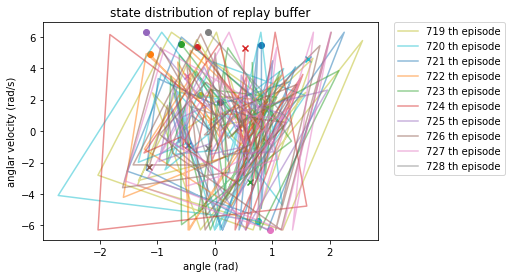

In [23]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(a.state_memory):
    if i<len(a.state_memory)-10:
        continue
    print(em.shape)
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i % 10])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i % 10])
    plt.plot(em[:,0], em[:,1], color=cycle[i % 10], label=f'{i+1} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of replay buffer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.xlim(-10, 10)
plt.show()

In [36]:
from rl2.memory import sample_batch_indexes
#sbi = sample_batch_indexes(low=a.memory.window_length, high=a.memory.nb_entries-1, size=50000)
sbi = batch_idxs = np.array(range(1,49999))
replay_buffer = a.memory.sample(49998, batch_idxs=sbi)

In [63]:
df = []
for e in replay_buffer:
    column = np.hstack((e.state0[0], e.action, e.reward, e.state1[0], e.terminal1))
    df.append(column)
df = np.array(df)

In [64]:
import pandas as pd

columns = ['theta0', 'theta_dot0', 'input', 'tau', 'reward', 'theta1', 'theta_dot1', 'terminal1']
df = pd.DataFrame(df, columns=columns)
df.head()

,theta0,theta_dot0,input,tau,reward,theta1,theta_dot1,terminal1
0,-0.277374,1.606636,-0.328736,0.259345,0.214174,-0.009831,0.769811,0.0
1,-0.009831,0.769811,-1.835517,0.276267,0.261503,-0.035105,-0.701859,0.0
2,-0.035105,-0.701859,2.041459,0.301138,0.281593,0.031638,0.934061,0.0
3,0.031638,0.934061,-1.823623,0.189752,0.174403,0.105903,0.098661,0.0
4,0.105903,0.098661,-0.997172,0.318155,0.311136,0.052388,-0.396197,0.0


In [65]:
df.to_csv('./csv/replay_buffer.csv')

In [66]:
tmp = pd.read_csv('./csv/replay_buffer.csv', index_col=0)
arr = np.array(tmp.values)
arr.shape

(49998, 8)

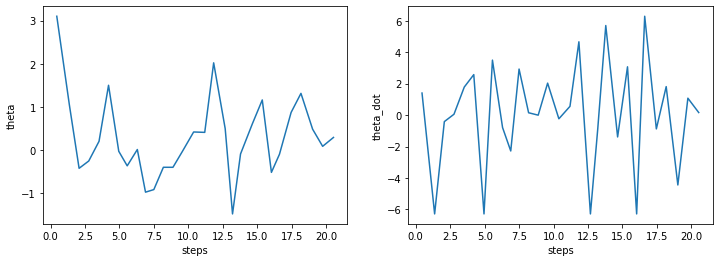

In [24]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
a.training = False
env.reset()
env.set_state(np.array([3.1, 1.4]))
states = []
time_limit = 20
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)
a.training = True

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

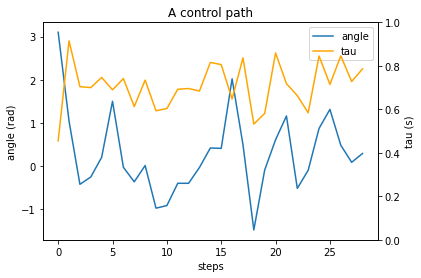

In [25]:
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.plot(states[:,0], label='angle')
ax2 = ax1.twinx()
ax2.plot(taus, color='orange', label='tau')
ax1.set_ylabel('angle (rad)')
ax2.set_ylabel('tau (s)')
plt.title('A control path')
ax1.set_xlabel('steps')
ax2.set_ylim(0.0,1.)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)#, loc='upper left')
plt.show()

In [37]:
mem = a.memory.sample(50000)
states = []
actions = []
for m in mem:
    states.append(m.state0[0])
    actions.append(m.action)
states = np.array(states)
actions = np.array(actions)

In [26]:
# actor = branch_actor((2,),(2,))
actor = a.actor

In [27]:
memory = []
l = 5.
for i in range(5000):
    env.reset()
    state0 = env.state
    a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
    memory.append([state0[0], state0[1], tau])
memory = np.array(memory)

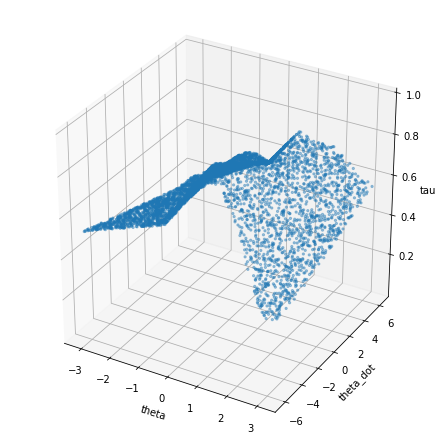

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,1.0)

ax.scatter3D(memory[:,0], memory[:,1], memory[:,2], marker='.', alpha=0.4)

In [16]:
from util import make_standup_agent
actor = make_standup_agent(actor, 0.01, env, verbose=True)


Epoch 1/50
30000/30000 [==============================] - 1s 34us/step - loss: 3.0028
Epoch 2/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.1366
Epoch 3/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0697
Epoch 4/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0600: 0s - loss
Epoch 5/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0565
Epoch 6/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0543
Epoch 7/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0520
Epoch 8/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0500
Epoch 9/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0480
Epoch 10/50
30000/30000 [==============================] - 0s 17us/step - loss: 0.0468
Epoch 11/50
30000/30000 [==============================] - 1s 20us/step - loss: 0.0454
Epoch 12/50
30000/30000 [===============

In [41]:
memory = []
l = 5.
ma = np.array([50.,50.])
for i in range(5000):
    state0 = np.random.uniform(low=-ma, high=ma)
    a_agent, tau = a.actor.predict_on_batch(np.array([[state0]]))[0]
    memory.append([state0[0], state0[1], tau])
memory = np.array(memory)

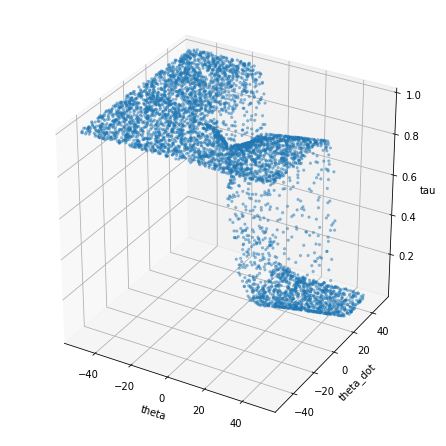

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,1.0)

ax.scatter3D(memory[:,0], memory[:,1], memory[:,2], marker='.', alpha=0.4)

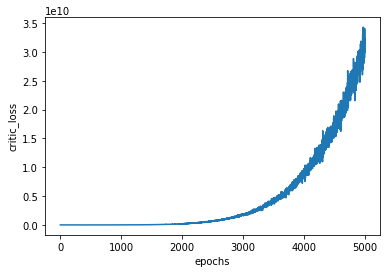

In [5]:

critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
epoch = 5000
gamma = 0.99
arr = np.array(range(a.memory.nb_entries))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = a.memory.sample(a.batch_size)
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append(m[0])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append(m[3])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = a.actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    r_second = gamma * critic.predict_on_batch(state1_batch_with_action)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [81]:
b = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=0.00001, clipnorm=1.), Adam(lr=0.001, clipnorm=1.)
optimizer = [actor_optimizer, critic_optimizer]
b.compile(optimizer=optimizer, metrics=["mae"], action_lr=0.0001, tau_lr=0.001)
b.actor = make_standup_agent(b.actor, .01, env, verbose=False)

In [83]:
high = np.pi*np.ones(2,)
for _ in range(10):
    x = np.random.uniform(low=-high, high=high)
    print(a.forward(x))
    print(b.forward(x))
    print()

[-9.999739    0.99985254]
[7.5273170e+00 1.1540558e-03]

[-9.9993334e+00  1.6408312e-03]
[-9.9987640e+00  1.0019746e-03]

[-9.996586   0.9999012]
[-9.9658031e+00  1.3005352e-03]

[-9.979913  0.992833]
[-4.9645996   0.00899488]

[-9.997153    0.98591346]
[-9.9988823e+00  1.4370666e-03]

[-9.986576   0.9879084]
[8.350636e+00 7.411491e-03]

[-9.990459   0.9998548]
[-9.8650093e+00  1.0889925e-03]

[-9.999501   0.9999189]
[9.9987040e+00 1.0350916e-03]

[-9.9999485   0.99451745]
[9.9657211e+00 3.3374643e-03]

[-9.999114   0.9999795]
[9.9980927e+00 1.0244658e-03]



In [84]:
ap = NN_params(a.actor)
bp = NN_params(b.actor)
dif = bp - ap

In [129]:
b.actor = make_standup_agent(b.actor, 1., env, verbose=False)

In [130]:
high = np.pi*np.ones(2,)
for _ in range(10):
    x = np.random.uniform(low=-high, high=high)
    print(b.forward(x))

    print()

[9.999999  0.9999999]

[10.  1.]

[-9.955486   0.9999957]

[-9.993748   0.9999999]

[9.999975  0.9999995]

[-8.448686    0.99998426]

[-9.999074    0.99999976]

[-9.894086  1.      ]

[10.  1.]

[10.          0.99999976]



In [83]:
A = np.array([[0,1],[15,0]])
v, p = np.linalg.eig(A)
align = np.array([[v[0], 0],[0, v[1]]])
print(np.dot(np.dot(p, align), np.linalg.inv(p)))
exp = np.exp(align)
np.dot(np.dot(p, exp), np.linalg.inv(p))

[[0.00000000e+00 1.00000000e+00]
 [1.50000000e+01 2.77555756e-16]]


array([[23.05321231,  6.20514315],
       [93.07714722, 25.05321231]])

In [13]:
hypara = [env.m, env.l, env.g]
def next_state_gradient(state0, action, tau, hypara):
    # linear system
    m, l, g = hypara
    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([0, 3/(m*l**2)])
    
    # ∂s'/∂τ
    dsdt = np.dot(np.dot(A, _array_exp(A*tau)), state0) + B*action

    # ∂s'/∂u
    dsdu = np.dot(np.dot(_array_exp(A*tau), np.linalg.inv(A)), B) \
         - np.dot(np.dot(_array_exp(A*tau), np.linalg.inv(A)), np.dot(_array_exp(-A*tau), B))

    return [dsdt, dsdu]


def _array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out

In [7]:
ddf = pd.read_csv('./csv/replay_buffer.csv', index_col=0)
replay = np.array(ddf.values)
state0_batch = replay[:,:2]
action_batch = replay[:,2:4]
reward_batch = replay[:,4]
state1_batch = replay[:,5:7]

In [11]:
state0 = state0_batch[0]
a = action_batch[0]
print([state0][0], a)

[-0.2773736   1.60663564] [-0.32873622  0.25934513]


In [14]:
%%time
next_state_gradient(state0, a[0], a[1], hypara)

CPU times: user 1.99 ms, sys: 1.33 ms, total: 3.32 ms
Wall time: 2.59 ms


[array([2.82436345, 4.08783382]), array([0.3289878 , 2.74686639])]

In [12]:
for i in range(100):
    print(np.random.randn() / 10.)

-0.0970608029953959
0.15116262056916585
0.05818486712736896
0.08177576295050812
-0.08180526280739064
0.1420079211452558
0.02516271214190799
-0.01791956643402966
-0.0030471947288104864
0.01531786446081915
0.07532886411863746
0.01975841849215428
-0.059284444999791276
-0.03037734258609946
-0.16166083146895563
0.05261081509662122
0.020222215108965474
-0.13949450681266407
0.12255728888415732
-0.10807949024840413
-0.0019112280286736258
-0.02020088339812426
-0.05284078482221315
0.1984202935199543
0.16013686999308213
-0.0863885833339992
0.008012112528796357
-0.07880850666220049
0.1295953651553513
0.07364070748514223
0.010446720382734892
-0.08538366982498571
0.06065356653674657
-0.06773266027490148
-0.0016946122011353034
0.22179272211273054
0.20866918792605885
0.017017075672912444
0.04710594476130218
0.0036776098556470854
0.15321477743988848
0.0038307844365570733
-0.045526168786666724
-0.0013438434755417676
0.05890579136763956
-0.030448179164840234
-0.18652077753906438
0.07669867219327525
-0.16

In [42]:
sqrt(4)

NameError: name 'sqrt' is not defined